<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Assignment10/Kernels_and_Activations_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and modules**

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

from keras.datasets import mnist

Using TensorFlow backend.


# GRADCAM

Let's start with a pretrained VGG model

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2

1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [3]:
model = VGG16(weights="imagenet")

W0707 05:48:13.128118 140405012342656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 05:48:13.173551 140405012342656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 05:48:13.182840 140405012342656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 05:48:13.224058 140405012342656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 30s 0us/step


W0707 05:48:44.637898 140405012342656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 05:48:44.639434 140405012342656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [4]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [0]:
import keras.backend as K
from skimage import io

def GradCAM(image, output, last_layer):
  print(image.shape)
  grads = K.gradients(output, last_layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow( image)
  cv2_imshow(superimposed_img)

In [0]:

dog = io.imread("https://www.rspcapetinsurance.org.au/rspca/media/images/hero/dog-insurance-hero.jpg")
dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(dog)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

180
(224, 224, 3)
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


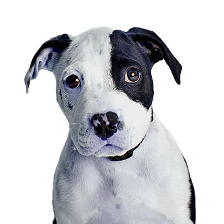

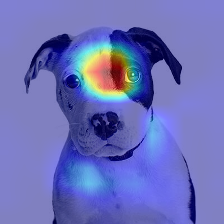

(224, 224, 3)
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


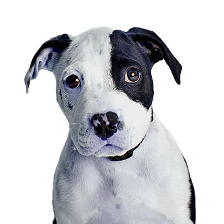

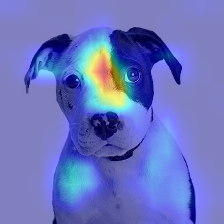

(224, 224, 3)
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


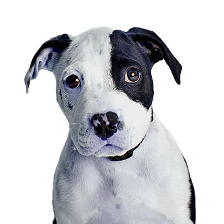

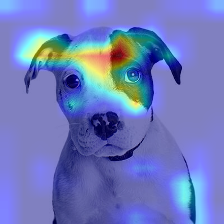

In [16]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")
GradCAM(dog, class_output, last_conv_layer)
last_conv_layer = model.get_layer("block5_conv2")
GradCAM(dog, class_output, last_conv_layer)
last_conv_layer = model.get_layer("block5_conv1")
GradCAM(dog, class_output, last_conv_layer)

In [6]:
!wget "https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg"

--2019-07-07 05:49:20--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.244.83, 190.93.246.83, 190.93.245.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.244.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68503 (67K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’

16_scale_tony_stark 100%[===================>]  66.90K  --.-KB/s    in 0.001s  

2019-07-07 05:49:20 (61.1 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’ saved [68503/68503]



In [0]:
import urllib
from skimage import io

#resp = urllib.urlopen(url)
#tonystark = np.asarray(bytearray(resp.read()), dtype="uint8")
#tonystark = cv2.imdecode(tonystark, cv2.IMREAD_COLOR)
tonystark = io.imread("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")

tonystark = cv2.resize(tonystark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(tonystark)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

(224, 224, 3)
(?, 14, 14, 512)
(512,)
(14, 14, 512)
(14, 14)


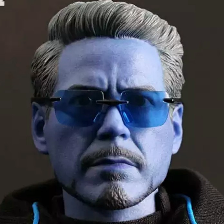

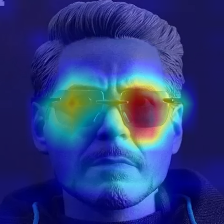

In [18]:
#n04356056
#837/6

preds = model.predict(x)
class_idx = 837
#print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")
GradCAM(tonystark, class_output, last_conv_layer)